In [1]:
from eomaps import Maps
import netCDF4 as nc
import numpy as np
import pandas as pd
import heapq
import math 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.spatial import Voronoi
import copy
import matplotlib.cm as cm
from scipy.spatial import KDTree
import requests
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [2]:
import math

def haversine_distance(p1, p2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert the coordinates to radians
    lat1 = math.radians(p1[0])
    lon1 = math.radians(p1[1])
    lat2 = math.radians(p2[0])
    lon2 = math.radians(p2[1])

    # Differences in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance
    distance = R * c

    return distance

In [3]:
def angle_between(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.arccos(dot_product / norm_product)

In [4]:
def is_within_ellipse(point, start, goal, semi_major_axis, semi_minor_axis):
    # Translate the system so the center of the ellipse is at the origin
    center = ((start[0] + goal[0]) / 2, (start[1] + goal[1]) / 2)
    translated_point = (point[0] - center[0], point[1] - center[1])

    # Rotate the system so the ellipse is aligned with the axes
    angle = np.arctan2(goal[1] - start[1], goal[0] - start[0])
    rotated_point = (translated_point[0] * np.cos(angle) + translated_point[1] * np.sin(angle),
                     -translated_point[0] * np.sin(angle) + translated_point[1] * np.cos(angle))

    # Check if the point is within the ellipse
    return (rotated_point[0] / semi_major_axis) ** 2 + (rotated_point[1] / semi_minor_axis) ** 2 <= 1

In [5]:
def split_altitude(altitude):
    # Split the altitude string on the '/' character
    lower, upper = altitude.split('/')

    # Remove the 'FL' prefix and convert to integers
    lower = int(lower.replace('FL', ''))
    upper = int(upper.replace('FL', ''))

    midpoint = ((lower + upper) / 2)  * 100

    return midpoint

In [6]:
print("midpoint in feet: ", split_altitude("FL350/FL390"))

midpoint in feet:  37000.0


In [7]:
# Sample data: Altitude in feet and corresponding pressure in mbar
altitude_ft = np.array([-5000, -4000, -3000, -2000, -1000, 0, 1000, 2000, 3000, 4000, 5000,
                        6000, 7000, 8000, 9000, 10000, 15000, 20000, 25000, 30000, 35000, 
                        40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 
                        85000, 90000, 95000, 100000])

pressure_mbar = np.array([1210.23, 1168.55, 1128.03, 1088.66, 1050.41, 1013.25, 977.166, 
                          942.129, 908.117, 875.105, 843.073, 811.996, 781.854, 752.624, 
                          724.285, 696.817, 571.820, 465.633, 376.009, 300.896, 238.423, 
                          187.54, 147.48, 115.97, 91.199, 71.717, 56.397, 44.377, 34.978, 
                          27.615, 21.837, 17.296, 13.721, 10.902])

In [8]:
def altitude_pressure_model_and_prediction(altitude_ft, pressure_mbar, prediction_altitude, degree=5):
    coeffs = np.polyfit(altitude_ft, pressure_mbar, degree)
    polynomial = np.poly1d(coeffs)

    # Return the predicted pressure at the given altitude
    return polynomial(prediction_altitude)

# Example usage
print(f"Pressure at 10,000 ft: {altitude_pressure_model_and_prediction(altitude_ft, pressure_mbar, 10000):.2f} mbar")

Pressure at 10,000 ft: 696.66 mbar


In [9]:
# Open the NetCDF file and read the data once
ds = nc.Dataset('/Users/beltran/Documents/University Year 4/Capstone Project/Airmap/datasets/2022-01-31.nc', 'r')
wind_u = ds.variables['wind_u'][:]
wind_v = ds.variables['wind_v'][:]
latitudes = ds.variables['lat'][:]
longitudes = ds.variables['lon'][:]
levels = ds.variables['level'][:]
temperature = ds.variables['temperature'][:]

def get_weather_data(lat, lon, level):
    # Open a NetCDF file
    # Find the index of the closest latitude, longitude, and level to the ones specified
    lat_index = (np.abs(latitudes - lat)).argmin()
    lon_index = (np.abs(longitudes - lon)).argmin()
    level_index = (np.abs(levels - level)).argmin()

    # Access the wind components at the specified coordinates
    wind_u_value = wind_u[0, level_index, lat_index, lon_index]
    wind_v_value = wind_v[0, level_index, lat_index, lon_index]

    temperature_value_k = temperature[0, level_index, lat_index, lon_index]
    temperature_value_c = temperature_value_k - 273.15

    # Calculate the wind speed and direction
    wind_speed = np.sqrt(wind_u_value**2 + wind_v_value**2)
    wind_direction = (270 - (np.arctan2(wind_v_value, wind_u_value) * (180/np.pi))) % 360

    return wind_speed, wind_direction, temperature_value_c

In [10]:
df = pd.read_csv('/Users/beltran/Documents/University Year 4/Capstone Project/Airmap/datasets/waypoints_graph_zones_grouped.csv')

In [11]:
waypoints = {}
# Iterate over rows of df
for index, row in df.iterrows():
    waypoint_id = row['name']
    lat = row['decimal_lat']
    lon = row['decimal_lon']
    fra_zone = row['fra_zone']
    fra_status = row['fra_status']
    fra_airspace = row['fra_airspace']
    altitude = row['altitude']
    waypoints[waypoint_id] = {'coordinates': (float(lat), float(lon)), 'fra_zone': fra_zone, 'fra_status': fra_status, 'fra_airspace': fra_airspace, 'altitude': altitude}

print("waypoints:", waypoints)

waypoints: {'ABAKU': {'coordinates': (51.676944444444445, 19.08138888888889), 'fra_zone': 'BALTIC & SEE FRA', 'fra_status': 'I', 'fra_airspace': 'EPWW', 'altitude': 'FL095 / FL660'}, 'ABERO': {'coordinates': (52.22777777777778, 23.20888888888889), 'fra_zone': 'BELFRA, BALTIC & SEE FRA', 'fra_status': 'EX', 'fra_airspace': 'UMMV,EPWW', 'altitude': 'FL305 / FL660'}, 'ABETI': {'coordinates': (47.67777777777778, 17.012777777777778), 'fra_zone': 'SECSI FRA, BALTIC & SEE FRA', 'fra_status': 'I', 'fra_airspace': 'LOVV', 'altitude': '5500 FT / FL245'}, 'ABEZE': {'coordinates': (54.4325, 23.871944444444445), 'fra_zone': 'BALTIC & SEE FRA', 'fra_status': 'I', 'fra_airspace': 'EYVL', 'altitude': 'FL095 / FL660'}, 'ABITU': {'coordinates': (48.333333333333336, 18.32472222222222), 'fra_zone': 'BALTIC & SEE FRA', 'fra_status': '-', 'fra_airspace': 'LZBB', 'altitude': 'FL245 / FL660'}, 'ABLOM': {'coordinates': (48.0675, 17.087777777777777), 'fra_zone': 'SECSI FRA, BALTIC & SEE FRA', 'fra_status': 'X',

In [12]:
def path_distance(path):
    return sum(theGraph[path[i]]['neighbors'][path[i+1]] for i in range(len(path)-1))

def get_fra_zones(waypoints, waypoint_id):
    return set({zone.strip() for zone in waypoints[waypoint_id]['fra_zone'].split(',')})

def find_paths(graph, start, goal):
    stack = [(start, [start])]
    while stack:
        (node, path) = stack.pop()
        for next_node in set(graph[node]['neighbors'].keys()) - set(path):
            if next_node == goal:
                yield path + [next_node]
            else:
                stack.append((next_node, path + [next_node]))

def assign_wind_data(theGraph, paths, num_segments):
    segment_data = {}
    for path in paths:
        for i in range(len(path) - 1):
            node = path[i]
            neighbor = path[i + 1]
            total_wind_impact = 0
            total_distance = 0
            for j in range(1, num_segments):
                # Calculate intermediate coordinates
                altitude = theGraph[node]['altitude']
                midpoint_altitude = split_altitude(altitude)

                intermediate_coordinates = (
                    theGraph[node]['coordinates'][0] + j * (theGraph[neighbor]['coordinates'][0] - theGraph[node]['coordinates'][0]) / num_segments,
                    theGraph[node]['coordinates'][1] + j * (theGraph[neighbor]['coordinates'][1] - theGraph[node]['coordinates'][1]) / num_segments,
                )
                total_temperature = 0
                total_wind_speed = 0
                total_wind_direction = 0
                total_wind_direction_difference = 0
                # Get wind data for intermediate coordinates
                wind_speed, wind_direction, temperature = get_weather_data(intermediate_coordinates[0], intermediate_coordinates[1], altitude_pressure_model_and_prediction(altitude_ft, pressure_mbar, midpoint_altitude))

                total_temperature += temperature
                total_wind_speed += wind_speed
                total_wind_direction += wind_direction
                # Calculate the direction of travel along the segment
                travel_direction = math.atan2(theGraph[neighbor]['coordinates'][1] - theGraph[node]['coordinates'][1], theGraph[neighbor]['coordinates'][0] - theGraph[node]['coordinates'][0])
                # Calculate the difference between the wind direction and the travel direction
                wind_direction_difference = math.radians(wind_direction) - travel_direction
                # Calculate the component of the wind speed in the direction of travel
                wind_speed_component = wind_speed * math.cos(wind_direction_difference)
                # Calculate the impact of the wind on the segment
                wind_impact = wind_speed_component
                # Add wind impact to total wind impact
                total_wind_impact += wind_impact
                # Calculate distance to the next node
                distance_to_next = haversine_distance(intermediate_coordinates, theGraph[neighbor]['coordinates'])
                # Add distance to total distance
                total_distance += distance_to_next

                total_wind_direction_difference += wind_direction_difference
                # ... (same as before)
            # Calculate average wind direction difference
            avg_wind_direction_difference = total_wind_direction_difference / num_segments if num_segments > 0 else 0
            # Calculate average wind impact over the sum of segments
            avg_wind_impact = total_wind_impact / total_distance if total_distance > 0 else 0
            avg_wind_speed = total_wind_speed / num_segments
            avg_temperature = total_temperature / num_segments
            avg_wind_direction = total_wind_direction / num_segments
            # Assign average wind impact to the segment
            segment_data[(node, neighbor)] = {
                'distance': total_distance,
                'wind_impact': avg_wind_impact,
                'avg_wind_speed': avg_wind_speed,
                'avg_wind_direction': avg_wind_direction_difference,
                'avg_temperature': avg_temperature,
            }
    max_distance = max(segment_data[segment]['distance'] for segment in segment_data.keys())

    for segment in segment_data.keys():
        segment_data[segment]['normalized_distance'] = segment_data[segment]['distance'] / max_distance

    return segment_data

def get_neighbors(waypoints, current_node, current_node_fra_zones, goal_node, goal_node_fra_zones, start_node, theGraph, visited_nodes, nodes_to_visit, a, b):
    sorted_waypoints = dict(sorted(waypoints.items()))
    neighbors = [] 
    priority_queue = []
    neighbor_counts = {}
    max_shared_neighbors = 4
    eligible_nodes = [node for node in waypoints if node != goal_node and waypoints[node]['fra_status'] in ['EX', 'X', 'E'] and any(zone.strip() in goal_node_fra_zones for zone in waypoints[node]['fra_zone'].split(',')) and set(waypoints[node]['fra_zone'].split(',')) != set(goal_node_fra_zones)]
    min_distance_node = min(eligible_nodes, key=lambda node: haversine_distance(waypoints[node]['coordinates'], waypoints[start_node]['coordinates']) + haversine_distance(waypoints[node]['coordinates'], waypoints[goal_node]['coordinates']))
    for waypoint_id, waypoint_data in sorted_waypoints.items():
        waypoint_fra_zones = get_fra_zones(waypoints, waypoint_id)
        if waypoint_id != current_node and any(fra_zone in current_node_fra_zones for fra_zone in waypoint_fra_zones) and current_node_fra_zones != waypoint_fra_zones:
            #if waypoint_id in neighbor_counts and neighbor_counts[waypoint_id] >= max_shared_neighbors:
                #continue
            if any(waypoint_id in set(theGraph[node]['neighbors']) for node in theGraph):
                continue
            dist_to_goal = haversine_distance(waypoint_data['coordinates'], waypoints[goal_node]['coordinates'])
            current_to_goal_distance = haversine_distance(waypoints[current_node]['coordinates'], waypoints[goal_node]['coordinates'])
            if is_within_ellipse(waypoint_data['coordinates'], waypoints[start_node]['coordinates'], waypoints[goal_node]['coordinates'], a, b):
                if waypoint_data['fra_status'] in ['EX', 'X', 'E'] and dist_to_goal < current_to_goal_distance:
                    vector_to_best_from_current = np.array(waypoints[min_distance_node]['coordinates']) - np.array(waypoints[current_node]['coordinates'])
                    vector_to_best_waypoint_id = np.array(waypoints[min_distance_node]['coordinates']) - np.array(waypoints[waypoint_id]['coordinates'])
                    angle = angle_between(vector_to_best_from_current, vector_to_best_waypoint_id)
                    heapq.heappush(priority_queue, (angle, waypoint_id))
                    #print("Priority queue:", priority_queue)
                
    while priority_queue and len(neighbors) < 4:
        angle, waypoint_id = heapq.heappop(priority_queue)
        #print(current_node, waypoint_id)
        waypoint_data = waypoints[waypoint_id]
        dist = haversine_distance(waypoints[current_node]['coordinates'], waypoint_data['coordinates'])
        theGraph[current_node]['neighbors'][waypoint_id] = dist
        neighbors.append(waypoint_id)
        if waypoint_id not in neighbor_counts:
            neighbor_counts[waypoint_id] = 1
        else:
            neighbor_counts[waypoint_id] += 1
        if waypoint_id not in visited_nodes:
            heapq.heappush(nodes_to_visit, (angle, waypoint_id, visited_nodes + [waypoint_id]))
    return neighbors

def graph_same_fra_zone(waypoints, current_node, current_node_fra_zones, goal_node, goal_node_fra_zones, start_node, theGraph, visited_nodes, nodes_to_visit, a, b):
    dist_to_goal_from_start = haversine_distance(waypoints[start_node]['coordinates'], waypoints[goal_node]['coordinates'])
    theGraph[start_node]['neighbors'][goal_node] = dist_to_goal_from_start
    sorted_waypoints = dict(sorted(waypoints.items()))
    neighbors = [] 
    priority_queue = []
    neighbor_counts = {}
    max_shared_neighbors = 4
    eligible_nodes = [node for node in waypoints if node != goal_node and waypoints[node]['fra_status'] == 'I' and any(zone.strip() in goal_node_fra_zones for zone in waypoints[node]['fra_zone'].split(','))]
    min_distance_node = min(eligible_nodes, key=lambda node: haversine_distance(waypoints[node]['coordinates'], waypoints[start_node]['coordinates']) + haversine_distance(waypoints[node]['coordinates'], waypoints[goal_node]['coordinates']))
    for waypoint_id, waypoint_data in sorted_waypoints.items():
        waypoint_fra_zones = get_fra_zones(waypoints, waypoint_id)
        if waypoint_id != current_node and any(fra_zone in current_node_fra_zones for fra_zone in waypoint_fra_zones):
            if waypoint_id in neighbor_counts and neighbor_counts[waypoint_id] >= max_shared_neighbors:
                continue
            dist_to_goal = haversine_distance(waypoint_data['coordinates'], waypoints[goal_node]['coordinates'])
            current_to_goal_distance = haversine_distance(waypoints[current_node]['coordinates'], waypoints[goal_node]['coordinates'])
            if is_within_ellipse(waypoint_data['coordinates'], waypoints[start_node]['coordinates'], waypoints[goal_node]['coordinates'], a, b):
                if waypoint_data['fra_status'] == 'I' and dist_to_goal < current_to_goal_distance:
                    vector_to_best_from_current = np.array(waypoints[min_distance_node]['coordinates']) - np.array(waypoints[current_node]['coordinates'])
                    vector_to_best_waypoint_id = np.array(waypoints[min_distance_node]['coordinates']) - np.array(waypoints[waypoint_id]['coordinates'])
                    angle = angle_between(vector_to_best_from_current, vector_to_best_waypoint_id)
                    heapq.heappush(priority_queue, (angle, waypoint_id))
            
    while priority_queue and len(neighbors) < 4:
        angle, waypoint_id = heapq.heappop(priority_queue)
        waypoint_data = waypoints[waypoint_id]
        dist = haversine_distance(waypoints[current_node]['coordinates'], waypoint_data['coordinates'])
        dist_to_goal = haversine_distance(waypoint_data['coordinates'], waypoints[goal_node]['coordinates'])
        theGraph[current_node]['neighbors'][waypoint_id] = dist
        theGraph[waypoint_id]['neighbors'][goal_node] = dist_to_goal
        neighbors.append(waypoint_id)
        if waypoint_id not in neighbor_counts:
            neighbor_counts[waypoint_id] = 1
        else:
            neighbor_counts[waypoint_id] += 1
        if waypoint_id not in visited_nodes:
            heapq.heappush(nodes_to_visit, (angle, waypoint_id, visited_nodes + [waypoint_id]))
    return theGraph

def update_graph(waypoints, neighbors, goal_node, goal_node_fra_zones, theGraph):
    for neighbor in neighbors:
        neighbor_fra_zones = get_fra_zones(theGraph, neighbor)
        if neighbor_fra_zones.isdisjoint(goal_node_fra_zones):
            break
        else:
            if neighbors:
                for node in list(theGraph.keys()):  # Create a copy of the keys
                    for neighbor in list(theGraph[node]['neighbors'].keys()):
                        neighbor_fra_zones = get_fra_zones(theGraph, neighbor)
                        if neighbor_fra_zones.intersection(goal_node_fra_zones):
                            dist_to_goal = haversine_distance(theGraph[neighbor]['coordinates'], waypoints[goal_node]['coordinates'])
                            theGraph[neighbor]['neighbors'][goal_node] = dist_to_goal
    return theGraph

def integrate_wind(theGraph):
    for node in theGraph.keys():
        if theGraph[node]['neighbors']:  # Check if the node has any neighbors
            coordinates = theGraph[node]['coordinates']
            altitude = theGraph[node]['altitude']
            midpoint_altitude = split_altitude(altitude)
            wind_speed, wind_direction, temperature = get_weather_data(coordinates[0], coordinates[1], altitude_pressure_model_and_prediction(altitude_ft, pressure_mbar, midpoint_altitude))  # Get wind data for the node
            theGraph[node]['wind_speed'] = wind_speed  # Store the wind speed in the node's dictionary
            theGraph[node]['wind_direction'] = wind_direction  # Store the wind dir # Store the wind data in the node's dictionary
            theGraph[node]['temperature'] = temperature  # Store the temperature in the node's dictionary
    return theGraph

# Main function
def main():
    theGraph = {waypoint_id: {'coordinates': waypoint_data['coordinates'], 'fra_status': waypoint_data['fra_status'], 'fra_airspace': waypoint_data['fra_airspace'], 'fra_zone': waypoint_data['fra_zone'], 'altitude': waypoint_data['altitude'], 'neighbors': {}} for waypoint_id, waypoint_data in waypoints.items()}
    start_node = 'ABAKU'
    goal_node = 'ODNOS'

    start = waypoints[start_node]['coordinates']
    goal = waypoints[goal_node]['coordinates']

    nodes_to_visit = [(0, start_node, [])]

    start_node_fra_zones = get_fra_zones(waypoints, start_node)
    goal_node_fra_zones = get_fra_zones(waypoints, goal_node)

    a = math.sqrt((goal[0] - start[0])**2 + (goal[1] - start[1])**2) / 2
    b = a / 4

    if goal_node in theGraph[goal_node]['neighbors']:
        del theGraph[goal_node]['neighbors'][goal_node]
    
    if not start_node_fra_zones.isdisjoint(goal_node_fra_zones):
        while nodes_to_visit:
            _, current_node, visited_nodes = heapq.heappop(nodes_to_visit)
            current_node_fra_zones = get_fra_zones(waypoints, current_node)
            theGraph = graph_same_fra_zone(waypoints, current_node, current_node_fra_zones, goal_node, goal_node_fra_zones, start_node, theGraph, visited_nodes, nodes_to_visit, a, b)
        return theGraph

    while nodes_to_visit:
        _, current_node, visited_nodes = heapq.heappop(nodes_to_visit)
        current_node_fra_zones = get_fra_zones(waypoints, current_node)
        neighbors = get_neighbors(waypoints, current_node, current_node_fra_zones, goal_node, goal_node_fra_zones, start_node, theGraph, visited_nodes, nodes_to_visit, a, b)
        theGraph = update_graph(waypoints, neighbors, goal_node, goal_node_fra_zones, theGraph)
        
    return theGraph

start_node = 'ABAKU'
goal_node = 'ODNOS'

theGraph = main()

paths = list(find_paths(theGraph, start_node, goal_node))
paths.sort(key=path_distance)
five_shortest_paths = paths[:5]
theGraph = integrate_wind(theGraph)
segments = assign_wind_data(theGraph, five_shortest_paths, num_segments=10)

/var/folders/ng/n9ng0wy92t90_49j662nh02c0000gn/T/ipykernel_74822/738875448.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return np.arccos(dot_product / norm_product)


In [13]:
five_shortest_paths

[['ABAKU', 'VADRU', 'GISON', 'ODNOS'],
 ['ABAKU', 'VADRU', 'NINTA', 'ODNOS'],
 ['ABAKU', 'IVGOR', 'PENOR', 'ODNOS'],
 ['ABAKU', 'VADRU', 'ADAXA', 'ODNOS'],
 ['ABAKU', 'KUNER', 'LARMA', 'ODNOS']]

In [14]:
segments

{('ABAKU', 'VADRU'): {'distance': 2046.812872190132,
  'wind_impact': 0.09444845984936492,
  'avg_wind_speed': 2.1611998390706804,
  'avg_wind_direction': 0.5613012024527599,
  'avg_temperature': -5.579115905761716,
  'normalized_distance': 0.36900557893256236},
 ('VADRU', 'GISON'): {'distance': 119.5166506097064,
  'wind_impact': 1.279073796261477,
  'avg_wind_speed': 2.0709011220879754,
  'avg_wind_direction': 0.5636940749665195,
  'avg_temperature': -5.665444030761717,
  'normalized_distance': 0.021546821133250498},
 ('GISON', 'ODNOS'): {'distance': 5258.503583732877,
  'wind_impact': 0.025369895588563663,
  'avg_wind_speed': 2.1157090696691596,
  'avg_wind_direction': 0.5554138599359904,
  'avg_temperature': -6.7964987182617165,
  'normalized_distance': 0.9480188372853144},
 ('VADRU', 'NINTA'): {'distance': 300.3518687892048,
  'wind_impact': -0.11487101358309056,
  'avg_wind_speed': 1.78660632658887,
  'avg_wind_direction': 0.44944318469085565,
  'avg_temperature': -5.693764343261

In [15]:
graph = {}
for (node1, node2), data in segments.items():
    if node1 not in graph:
        graph[node1] = {'neighbors': {}}
    if node2 not in graph:
        graph[node2] = {'neighbors': {}}
    graph[node1]['neighbors'][node2] = {'distance': data['distance'], 'avg_wind_speed': data['avg_wind_speed'], 'avg_wind_direction': data['avg_wind_direction'], 'avg_temperature': data['avg_temperature']}

In [16]:
graph

{'ABAKU': {'neighbors': {'VADRU': {'distance': 2046.812872190132,
    'avg_wind_speed': 2.1611998390706804,
    'avg_wind_direction': 0.5613012024527599,
    'avg_temperature': -5.579115905761716},
   'IVGOR': {'distance': 1982.4121777977393,
    'avg_wind_speed': 2.1611998390706804,
    'avg_wind_direction': 0.5580957842948867,
    'avg_temperature': -5.579115905761716},
   'KUNER': {'distance': 1801.7718786514383,
    'avg_wind_speed': 2.0550517125115735,
    'avg_wind_direction': 0.5411077583122637,
    'avg_temperature': -5.566127624511717}}},
 'VADRU': {'neighbors': {'GISON': {'distance': 119.5166506097064,
    'avg_wind_speed': 2.0709011220879754,
    'avg_wind_direction': 0.5636940749665195,
    'avg_temperature': -5.665444030761717},
   'NINTA': {'distance': 300.3518687892048,
    'avg_wind_speed': 1.78660632658887,
    'avg_wind_direction': 0.44944318469085565,
    'avg_temperature': -5.693764343261717},
   'ADAXA': {'distance': 431.99842889243394,
    'avg_wind_speed': 1.7340

In [17]:
def calculate_fuel_consumption_no_wind(TAS, base_TAS, base_FCR, k, distance):
    # Adjust fuel consumption rate based on TAS
    FCR = base_FCR * (1 + (TAS - base_TAS) / base_TAS * k)
    
    # Calculate total fuel consumption
    flight_duration = distance / TAS
    total_fuel = flight_duration * FCR
    
    return total_fuel

In [18]:
def total_route_fuel_no_wind(graph, aircraft_type, paths):
    if aircraft_type == 'small':
        TAS = 150  # knots
        base_TAS = 120  # knots
        base_FCR = 30  # gallons per hour
        k = 0.02
    elif aircraft_type == 'commercial':
        TAS = 475  # knots
        base_TAS = 430  # knots
        base_FCR = 3000  # kg per hour
        k = 0.03
    else:
        raise ValueError("Invalid aircraft type. Choose either 'small' or 'commercial'.")

    path_fuel_consumptions = []
    for path in paths:
        total_fuel_consumption = 0
        for i in range(len(path) - 1):
            location = path[i]
            neighbor = path[i + 1]
            data = graph[location]['neighbors'][neighbor]

            # Calculate fuel for the leg to the neighbor without considering wind
            fuel = calculate_fuel_consumption_no_wind(
                TAS=TAS,
                base_TAS=base_TAS,
                base_FCR=base_FCR,
                k=k,
                distance=data['distance']
            )
            total_fuel_consumption += fuel

        path_fuel_consumptions.append((path, total_fuel_consumption))

    # Sort the paths by fuel consumption and return the five with the least consumption
    path_fuel_consumptions.sort(key=lambda x: x[1])
    return path_fuel_consumptions[:5]

In [19]:
def calculate_fuel_consumption(TAS, base_TAS, base_FCR, k, distance, wind_speed, wind_angle, temperature, reference_temp=15):
    # Calculate the effect of temperature on air density
    rho_actual = 1.225 * (273.15 + reference_temp) / (273.15 + temperature)  # Basic air density adjustment for temperature
    TAS_adjusted = TAS * (math.sqrt(rho_actual / 1.225))
    
    # Calculate ground speed
    wind_effect = wind_speed * math.cos(math.radians(wind_angle))
    GS = TAS_adjusted + wind_effect
    
    # Adjust fuel consumption rate based on TAS
    FCR = base_FCR * (1 + (TAS_adjusted - base_TAS) / base_TAS * k)
    
    # Calculate total fuel consumption
    flight_duration = distance / GS
    total_fuel = flight_duration * FCR
    
    return total_fuel

In [20]:
def total_route_fuel(graph, aircraft_type, paths):
    if aircraft_type == 'small':
        TAS = 150  # knots
        base_TAS = 120  # knots
        base_FCR = 30  # gallons per hour
        k = 0.02
    elif aircraft_type == 'commercial':
        TAS = 475  # knots
        base_TAS = 430  # knots
        base_FCR = 3000  # kg per hour
        k = 0.03
    else:
        raise ValueError("Invalid aircraft type. Choose either 'small' or 'commercial'.")

    path_fuel_consumptions = []
    for path in paths:
        total_fuel_consumption = 0
        for i in range(len(path) - 1):
            location = path[i]
            neighbor = path[i + 1]
            data = graph[location]['neighbors'][neighbor]

            # Calculate fuel for the leg to the neighbor
            fuel = calculate_fuel_consumption(
                TAS=TAS,
                base_TAS=base_TAS,
                base_FCR=base_FCR,
                k=k,
                distance=data['distance'],
                wind_speed=data['avg_wind_speed'],
                wind_angle=data['avg_wind_direction'],
                temperature=data['avg_temperature'],
                reference_temp=15
            )
            total_fuel_consumption += fuel

        path_fuel_consumptions.append((path, total_fuel_consumption))

    # Sort the paths by fuel consumption and return the five with the least consumption
    path_fuel_consumptions.sort(key=lambda x: x[1])
    return path_fuel_consumptions[:5]

In [21]:
total_route_fuel_no_wind(graph, 'small', five_shortest_paths)

[(['ABAKU', 'VADRU', 'GISON', 'ODNOS'], 1492.3914544130757),
 (['ABAKU', 'VADRU', 'NINTA', 'ODNOS'], 1504.0871020146647),
 (['ABAKU', 'IVGOR', 'PENOR', 'ODNOS'], 1526.4187655405008),
 (['ABAKU', 'VADRU', 'ADAXA', 'ODNOS'], 1529.5877102883824),
 (['ABAKU', 'KUNER', 'LARMA', 'ODNOS'], 1588.6074257540495)]

In [22]:
total_route_fuel_no_wind(graph, 'commercial', five_shortest_paths)

[(['ABAKU', 'VADRU', 'GISON', 'ODNOS'], 47040.90713100935),
 (['ABAKU', 'VADRU', 'NINTA', 'ODNOS'], 47409.55965246173),
 (['ABAKU', 'IVGOR', 'PENOR', 'ODNOS'], 48113.464587653776),
 (['ABAKU', 'VADRU', 'ADAXA', 'ODNOS'], 48213.35127297859),
 (['ABAKU', 'KUNER', 'LARMA', 'ODNOS'], 50073.681514021766)]

In [23]:
total_route_fuel(graph, 'small', five_shortest_paths)

[(['ABAKU', 'VADRU', 'GISON', 'ODNOS'], 1417.8503527364553),
 (['ABAKU', 'VADRU', 'NINTA', 'ODNOS'], 1429.136530312212),
 (['ABAKU', 'IVGOR', 'PENOR', 'ODNOS'], 1449.9333478529318),
 (['ABAKU', 'VADRU', 'ADAXA', 'ODNOS'], 1453.4828384829639),
 (['ABAKU', 'KUNER', 'LARMA', 'ODNOS'], 1508.8850942367517)]

In [24]:
total_route_fuel(graph, 'commercial', five_shortest_paths)

[(['ABAKU', 'VADRU', 'GISON', 'ODNOS'], 45121.287089842575),
 (['ABAKU', 'VADRU', 'NINTA', 'ODNOS'], 45477.97515959045),
 (['ABAKU', 'IVGOR', 'PENOR', 'ODNOS'], 46147.00264044989),
 (['ABAKU', 'VADRU', 'ADAXA', 'ODNOS'], 46250.985357254845),
 (['ABAKU', 'KUNER', 'LARMA', 'ODNOS'], 48026.21415501404)]

In [25]:
# Sum up the total fuel consumption for all paths
small_aircraft_fuel_no_wind_total = sum(fuel for path, fuel in total_route_fuel_no_wind(graph, 'small', five_shortest_paths))
commercial_aircraft_fuel_no_wind_total = sum(fuel for path, fuel in total_route_fuel_no_wind(graph, 'commercial', five_shortest_paths))
small_aircraft_fuel_wind_total = sum(fuel for path, fuel in total_route_fuel(graph, 'small', five_shortest_paths))
commercial_aircraft_fuel_wind_total = sum(fuel for path, fuel in total_route_fuel(graph, 'commercial', five_shortest_paths))

# Calculate the percentage increase in fuel consumption due to wind for both types of aircraft
small_aircraft_percentage_increase = abs((small_aircraft_fuel_wind_total - small_aircraft_fuel_no_wind_total) / small_aircraft_fuel_no_wind_total * 100)
commercial_aircraft_percentage_increase = abs((commercial_aircraft_fuel_wind_total - commercial_aircraft_fuel_no_wind_total) / commercial_aircraft_fuel_no_wind_total * 100)

# Print the percentage increases
print(f"Small aircraft fuel consumption increased by {small_aircraft_percentage_increase}% due to wind.")
print(f"Commercial aircraft fuel consumption increased by {commercial_aircraft_percentage_increase}% due to wind.")

# Compare the percentage increases
if small_aircraft_percentage_increase > commercial_aircraft_percentage_increase:
    print("The wind has a greater impact on small aircraft.")
else:
    print("The wind has a greater impact on commercial aircraft.")

Small aircraft fuel consumption increased by 4.9967239172598505% due to wind.
Commercial aircraft fuel consumption increased by 4.080324025409084% due to wind.
The wind has a greater impact on small aircraft.


In [26]:
df.columns = df.columns.str.strip()
node_to_coord = {node: data['coordinates'] for node, data in theGraph.items()}

def heuristic(node1, node2):
    coord1 = node_to_coord[node1]
    coord2 = node_to_coord[node2]
    haversine_dist = haversine_distance(coord1, coord2)
    return haversine_dist

In [27]:
def a_star(graph, start, goal):
    distances = {node: float('inf') for node in graph}
    distances[start] = 0

    priority_queue = [(0 + heuristic(start, goal), start, [start])]

    paths = []
    visited = set()

    while priority_queue:
        current_priority, current_node, path = heapq.heappop(priority_queue)
        visited.add(current_node)

        if current_node == goal:
            paths.append(path)
            if len(paths) == 10:
                return paths

        if current_node not in graph:
            continue

        for neighbor, weight in graph[current_node]['neighbors'].items():
            if neighbor in visited or neighbor not in graph:  # Check if the neighbor node exists in the graph
                continue

            distance = distances[current_node]

            if distance < distances.get(neighbor, float('inf')):  # Use get method to avoid KeyError
                distances[neighbor] = distance
                heapq.heappush(priority_queue, (distance + heuristic(neighbor, goal), neighbor, path + [neighbor]))
    return paths if paths else None

print(a_star(graph, 'ABAKU', 'ODNOS'))

[['ABAKU', 'VADRU', 'ADAXA', 'ODNOS']]


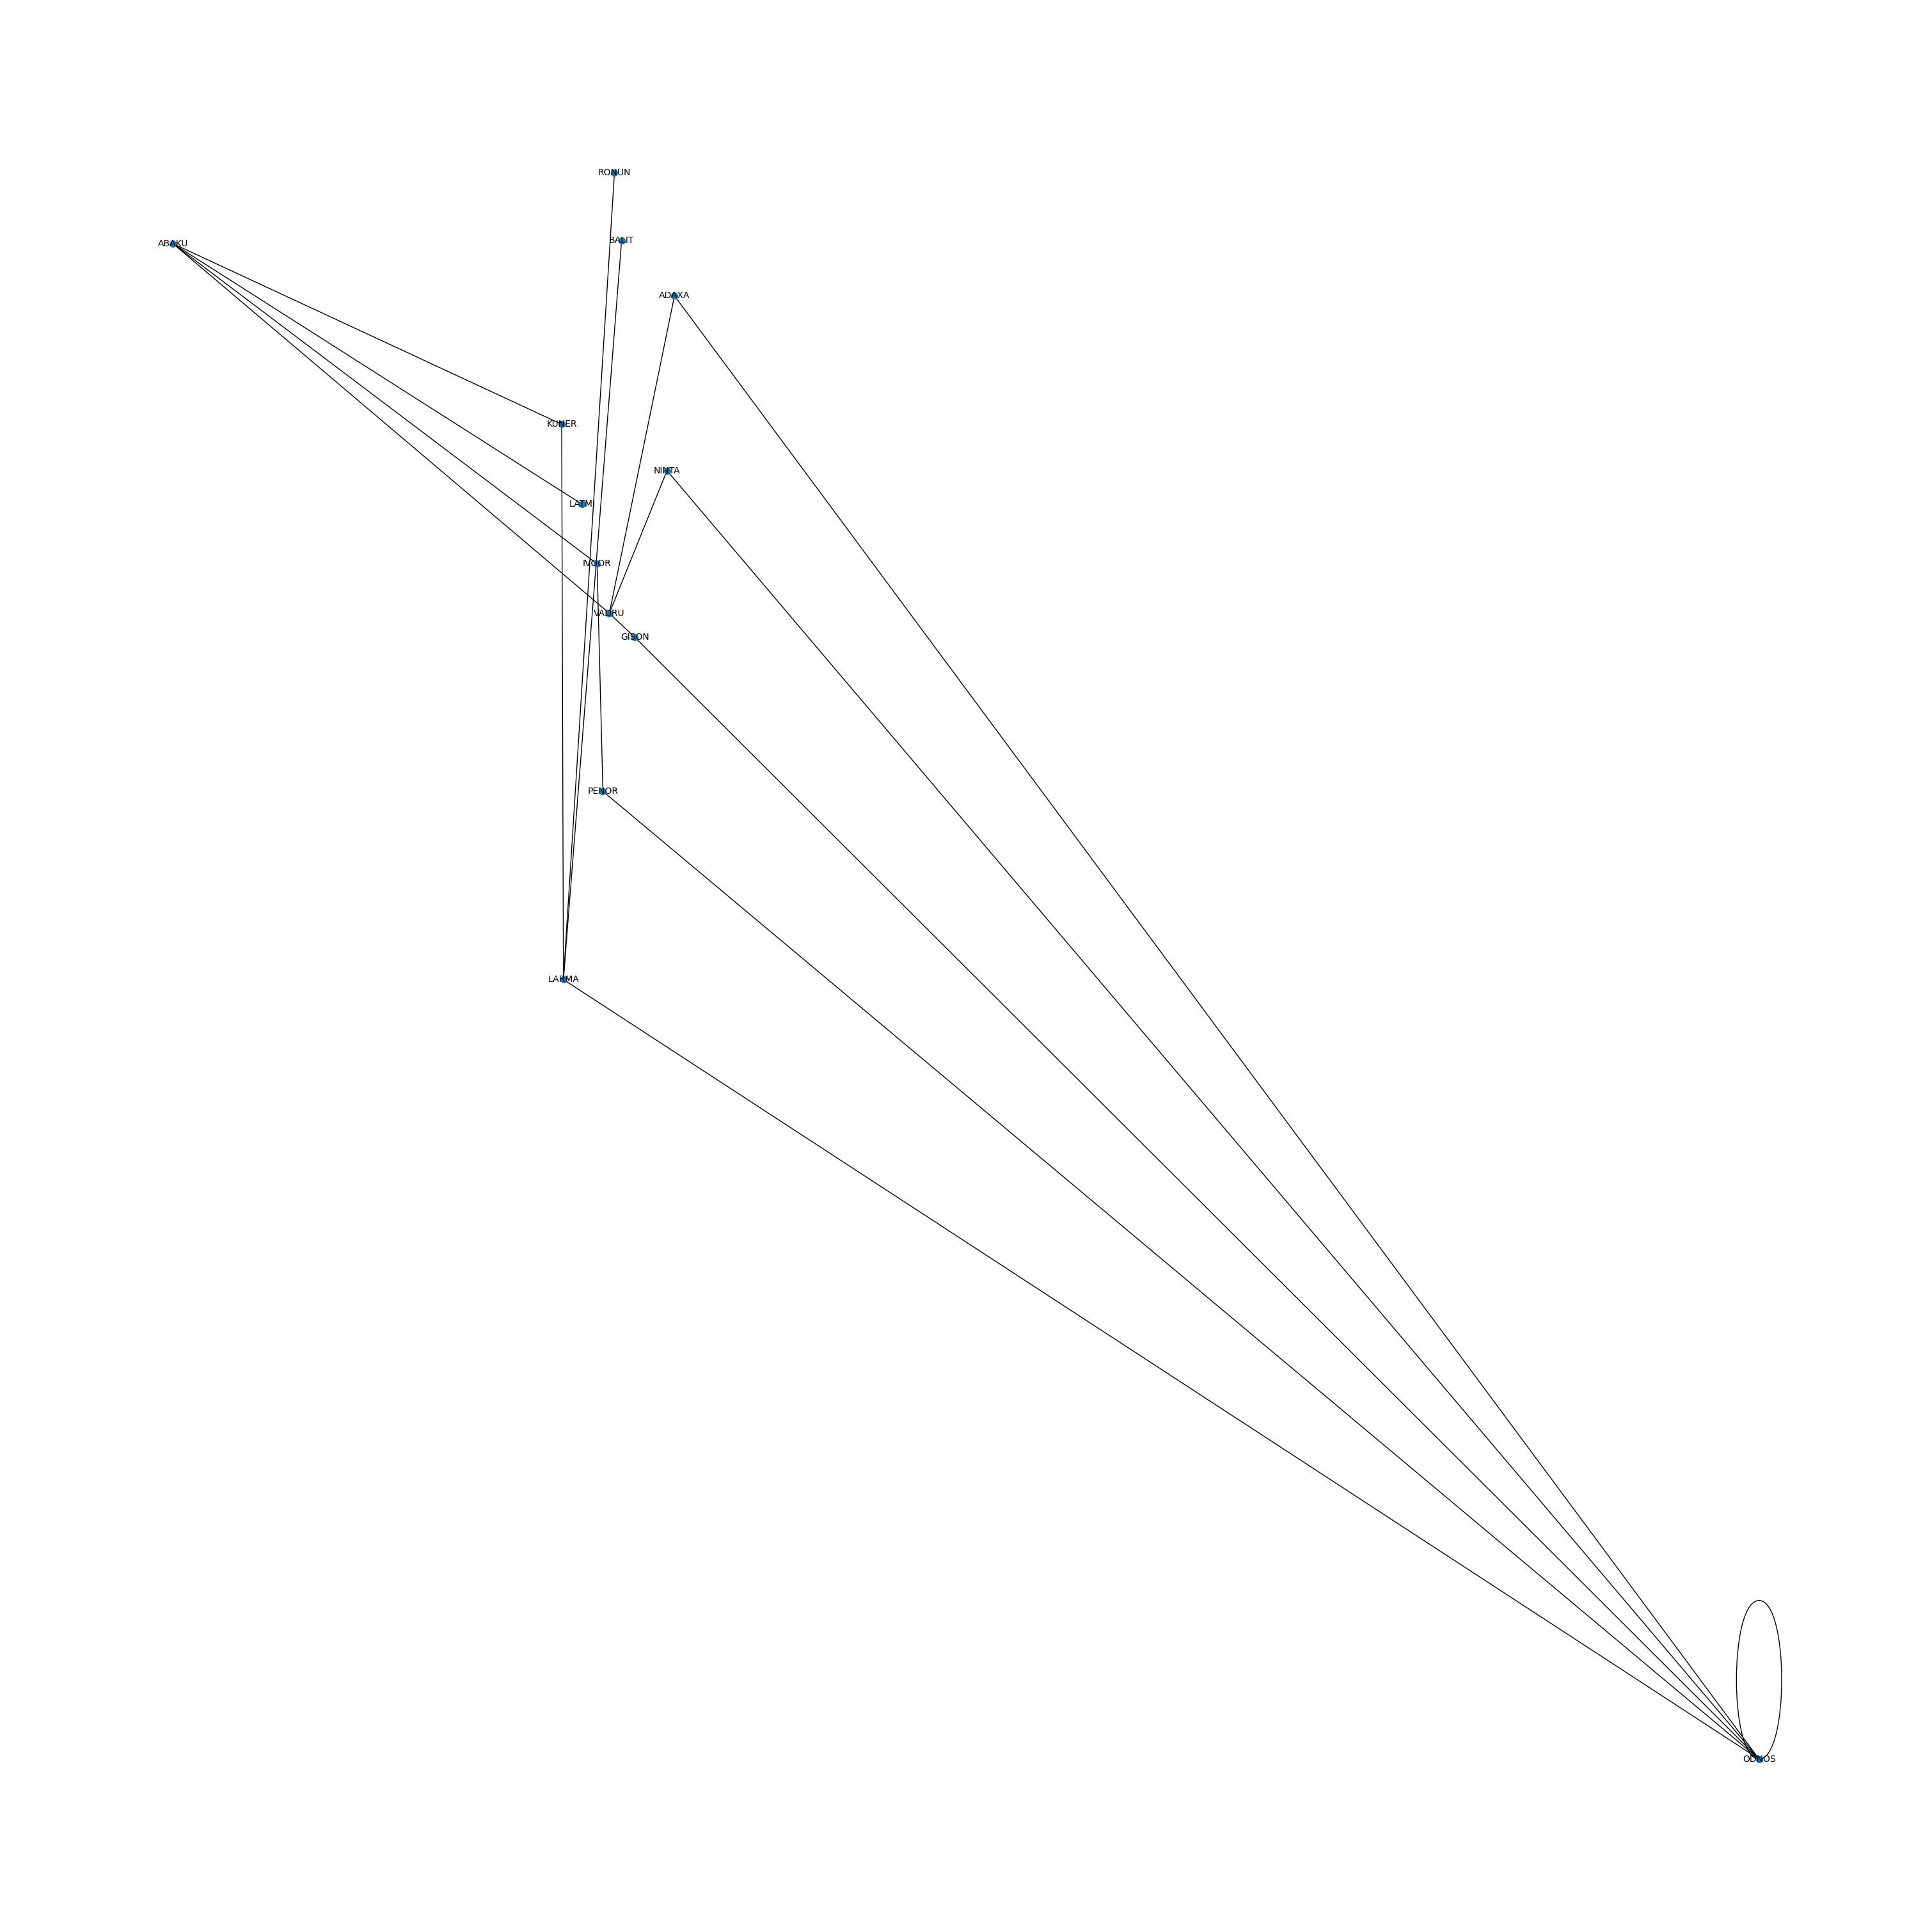

In [28]:
# Create a new graph
G = nx.Graph()

# Add nodes and edges to the graph
for node in theGraph:
    if 'neighbors' in theGraph[node]:
        for neighbor, weight in theGraph[node]['neighbors'].items():
            G.add_edge(node, neighbor, weight=weight)

# Extract coordinates for each node
pos = {node: theGraph[node]['coordinates'] for node in theGraph if 'coordinates' in theGraph[node]}

# Check that each node has a position
for node in G.nodes():
    if node not in pos:
        print(f"Node {node} does not have a position.")
        # You can assign a default position to the node if it does not have one
        pos[node] = (0, 0)
# Draw the graph
plt.figure(figsize=(30, 30))
nx.draw(G, pos, with_labels=True, node_size= 50, font_size=10)
plt.show()

/var/folders/ng/n9ng0wy92t90_49j662nh02c0000gn/T/ipykernel_74822/1820796061.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


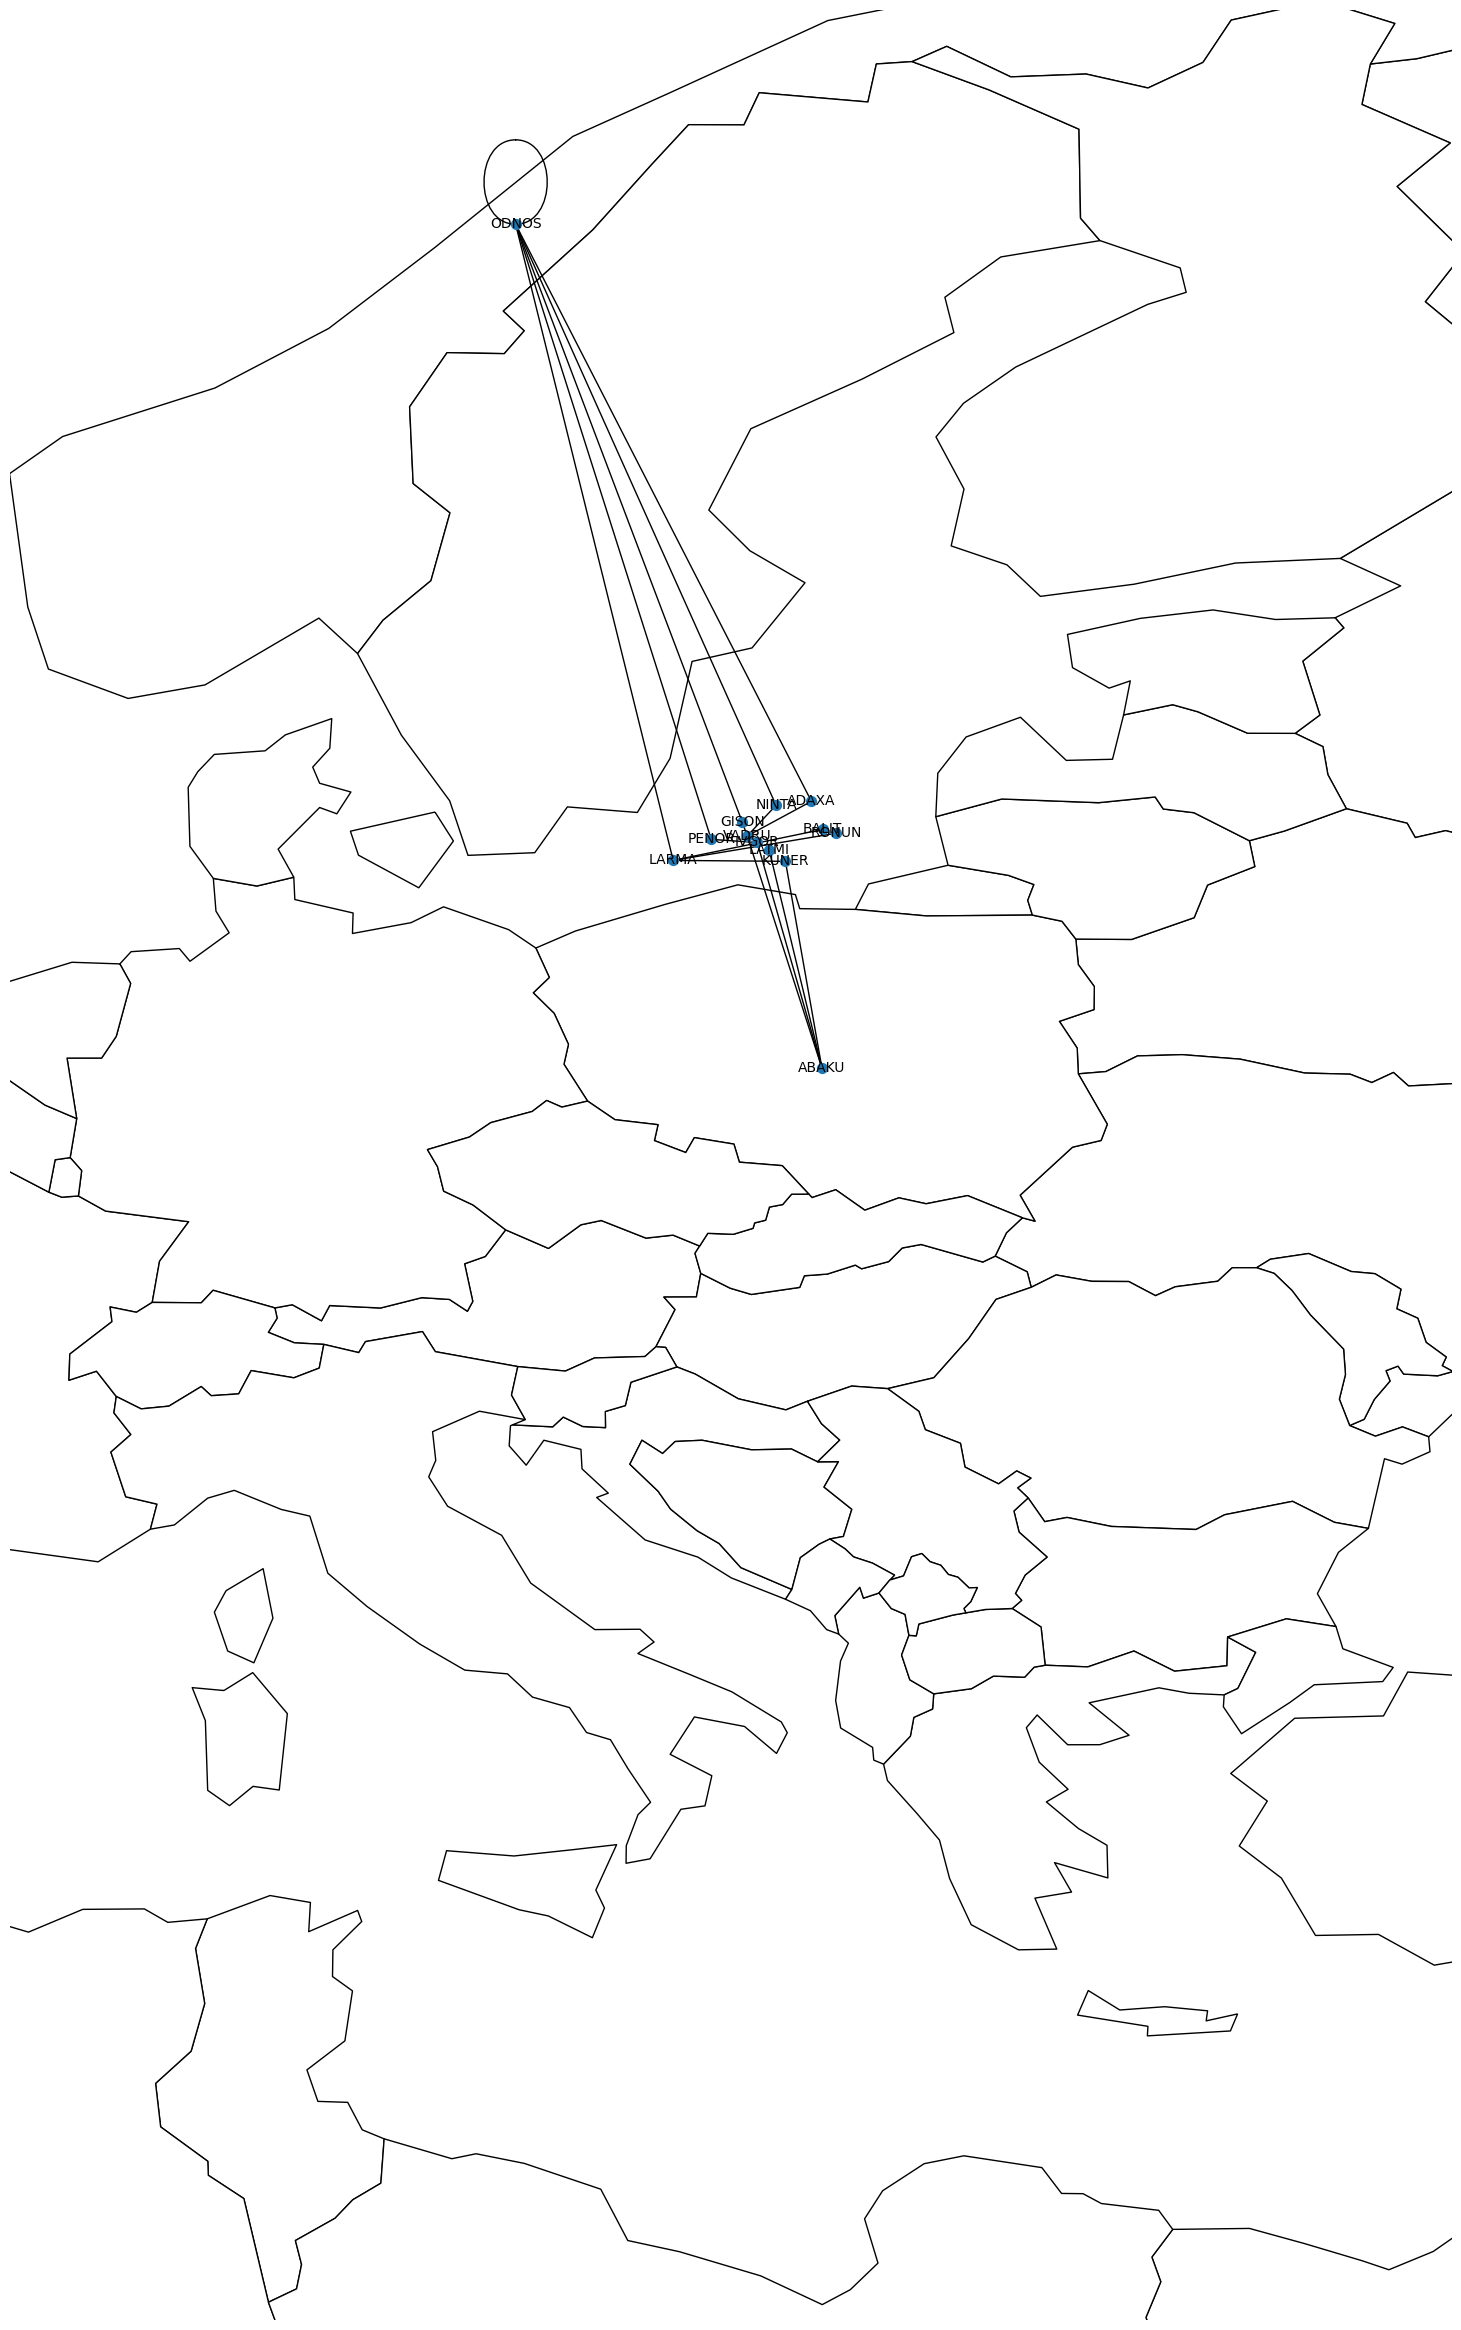

In [29]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a new graph
G = nx.Graph()

# Add nodes and edges to the graph
for node in theGraph:
    if 'neighbors' in theGraph[node]:
        for neighbor, weight in theGraph[node]['neighbors'].items():
            G.add_edge(node, neighbor, weight=weight)

# Extract coordinates for each node
pos = {node: (theGraph[node]['coordinates'][1], theGraph[node]['coordinates'][0]) for node in theGraph if 'coordinates' in theGraph[node]}

# Check that each node has a position
for node in G.nodes():
    if node not in pos:
        print(f"Node {node} does not have a position.")
        # You can assign a default position to the node if it does not have one
        pos[node] = (0, 0)

# Draw the map
fig, ax = plt.subplots(figsize=(30, 30))
world.plot(ax=ax, color='white', edgecolor='black')

# Draw the graph on the map
nx.draw(G, pos, with_labels=True, node_size=50, font_size=10, ax=ax)

# Set the limits of the plot to the bounding box of Europe
ax.set_xlim(5, 30)
ax.set_ylim(30, 70)


plt.show()

/var/folders/ng/n9ng0wy92t90_49j662nh02c0000gn/T/ipykernel_74822/1035942414.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


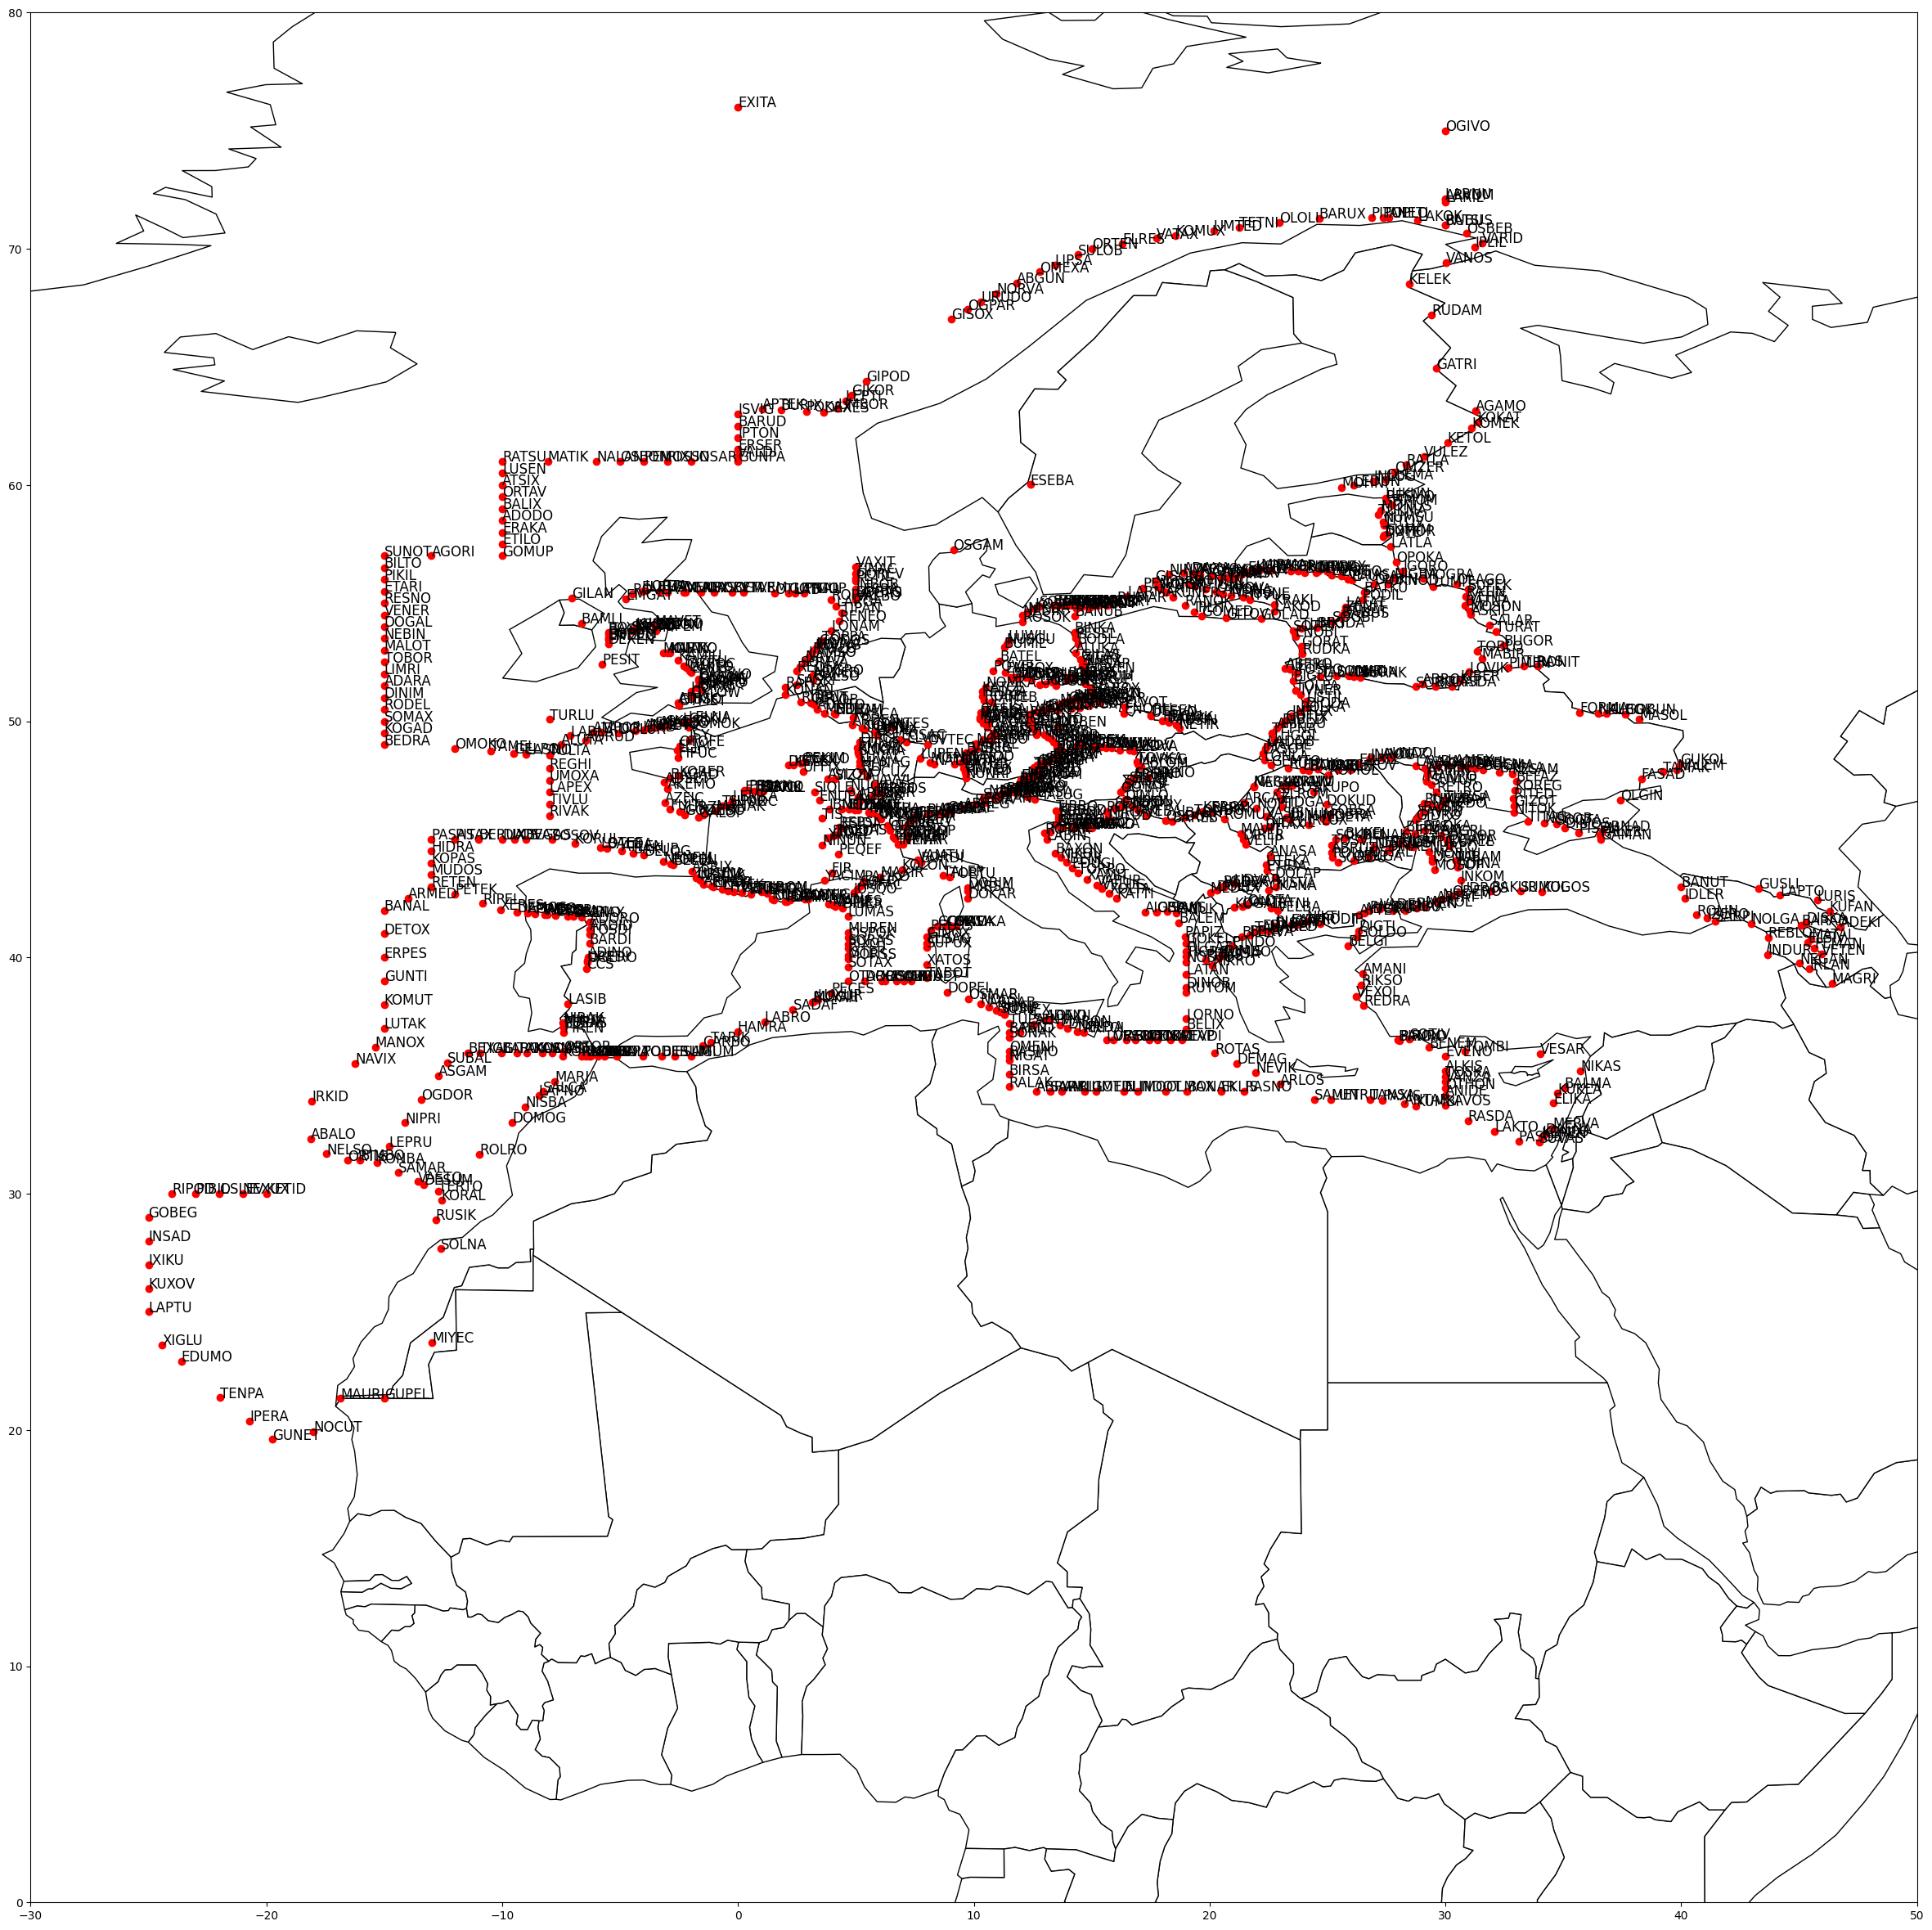

In [30]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

selected_fra_zone = 'MUAC FRA'  # Replace with your selected FRA zone

# Filter theGraph to only include points that are 'E', 'X', or 'EX' and belong to the selected FRA zone
filteredGraph = {node: data for node, data in waypoints.items() if data['fra_status'] in ['E', 'X', 'EX']} #and selected_fra_zone in data['fra_zone']}


# Extract coordinates for each node
pos = [(node, data['coordinates'][1], data['coordinates'][0]) for node, data in filteredGraph.items() if 'coordinates' in data]

# Draw the map
fig, ax = plt.subplots(figsize=(30, 30))
world.plot(ax=ax, color='white', edgecolor='black')

# Draw the points on the map
x_values = [coordinates[1] for coordinates in pos]
y_values = [coordinates[2] for coordinates in pos]
ax.scatter(x_values, y_values, color='red')

# Add labels to the points
for node, x, y in pos:
    ax.text(x, y, node, fontsize=12)

ax.set_xlim(-30, 50)
ax.set_ylim(0, 80)
# Set the limits of the plot to the bounding box of Europe


plt.show()

/var/folders/ng/n9ng0wy92t90_49j662nh02c0000gn/T/ipykernel_74822/2988002975.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


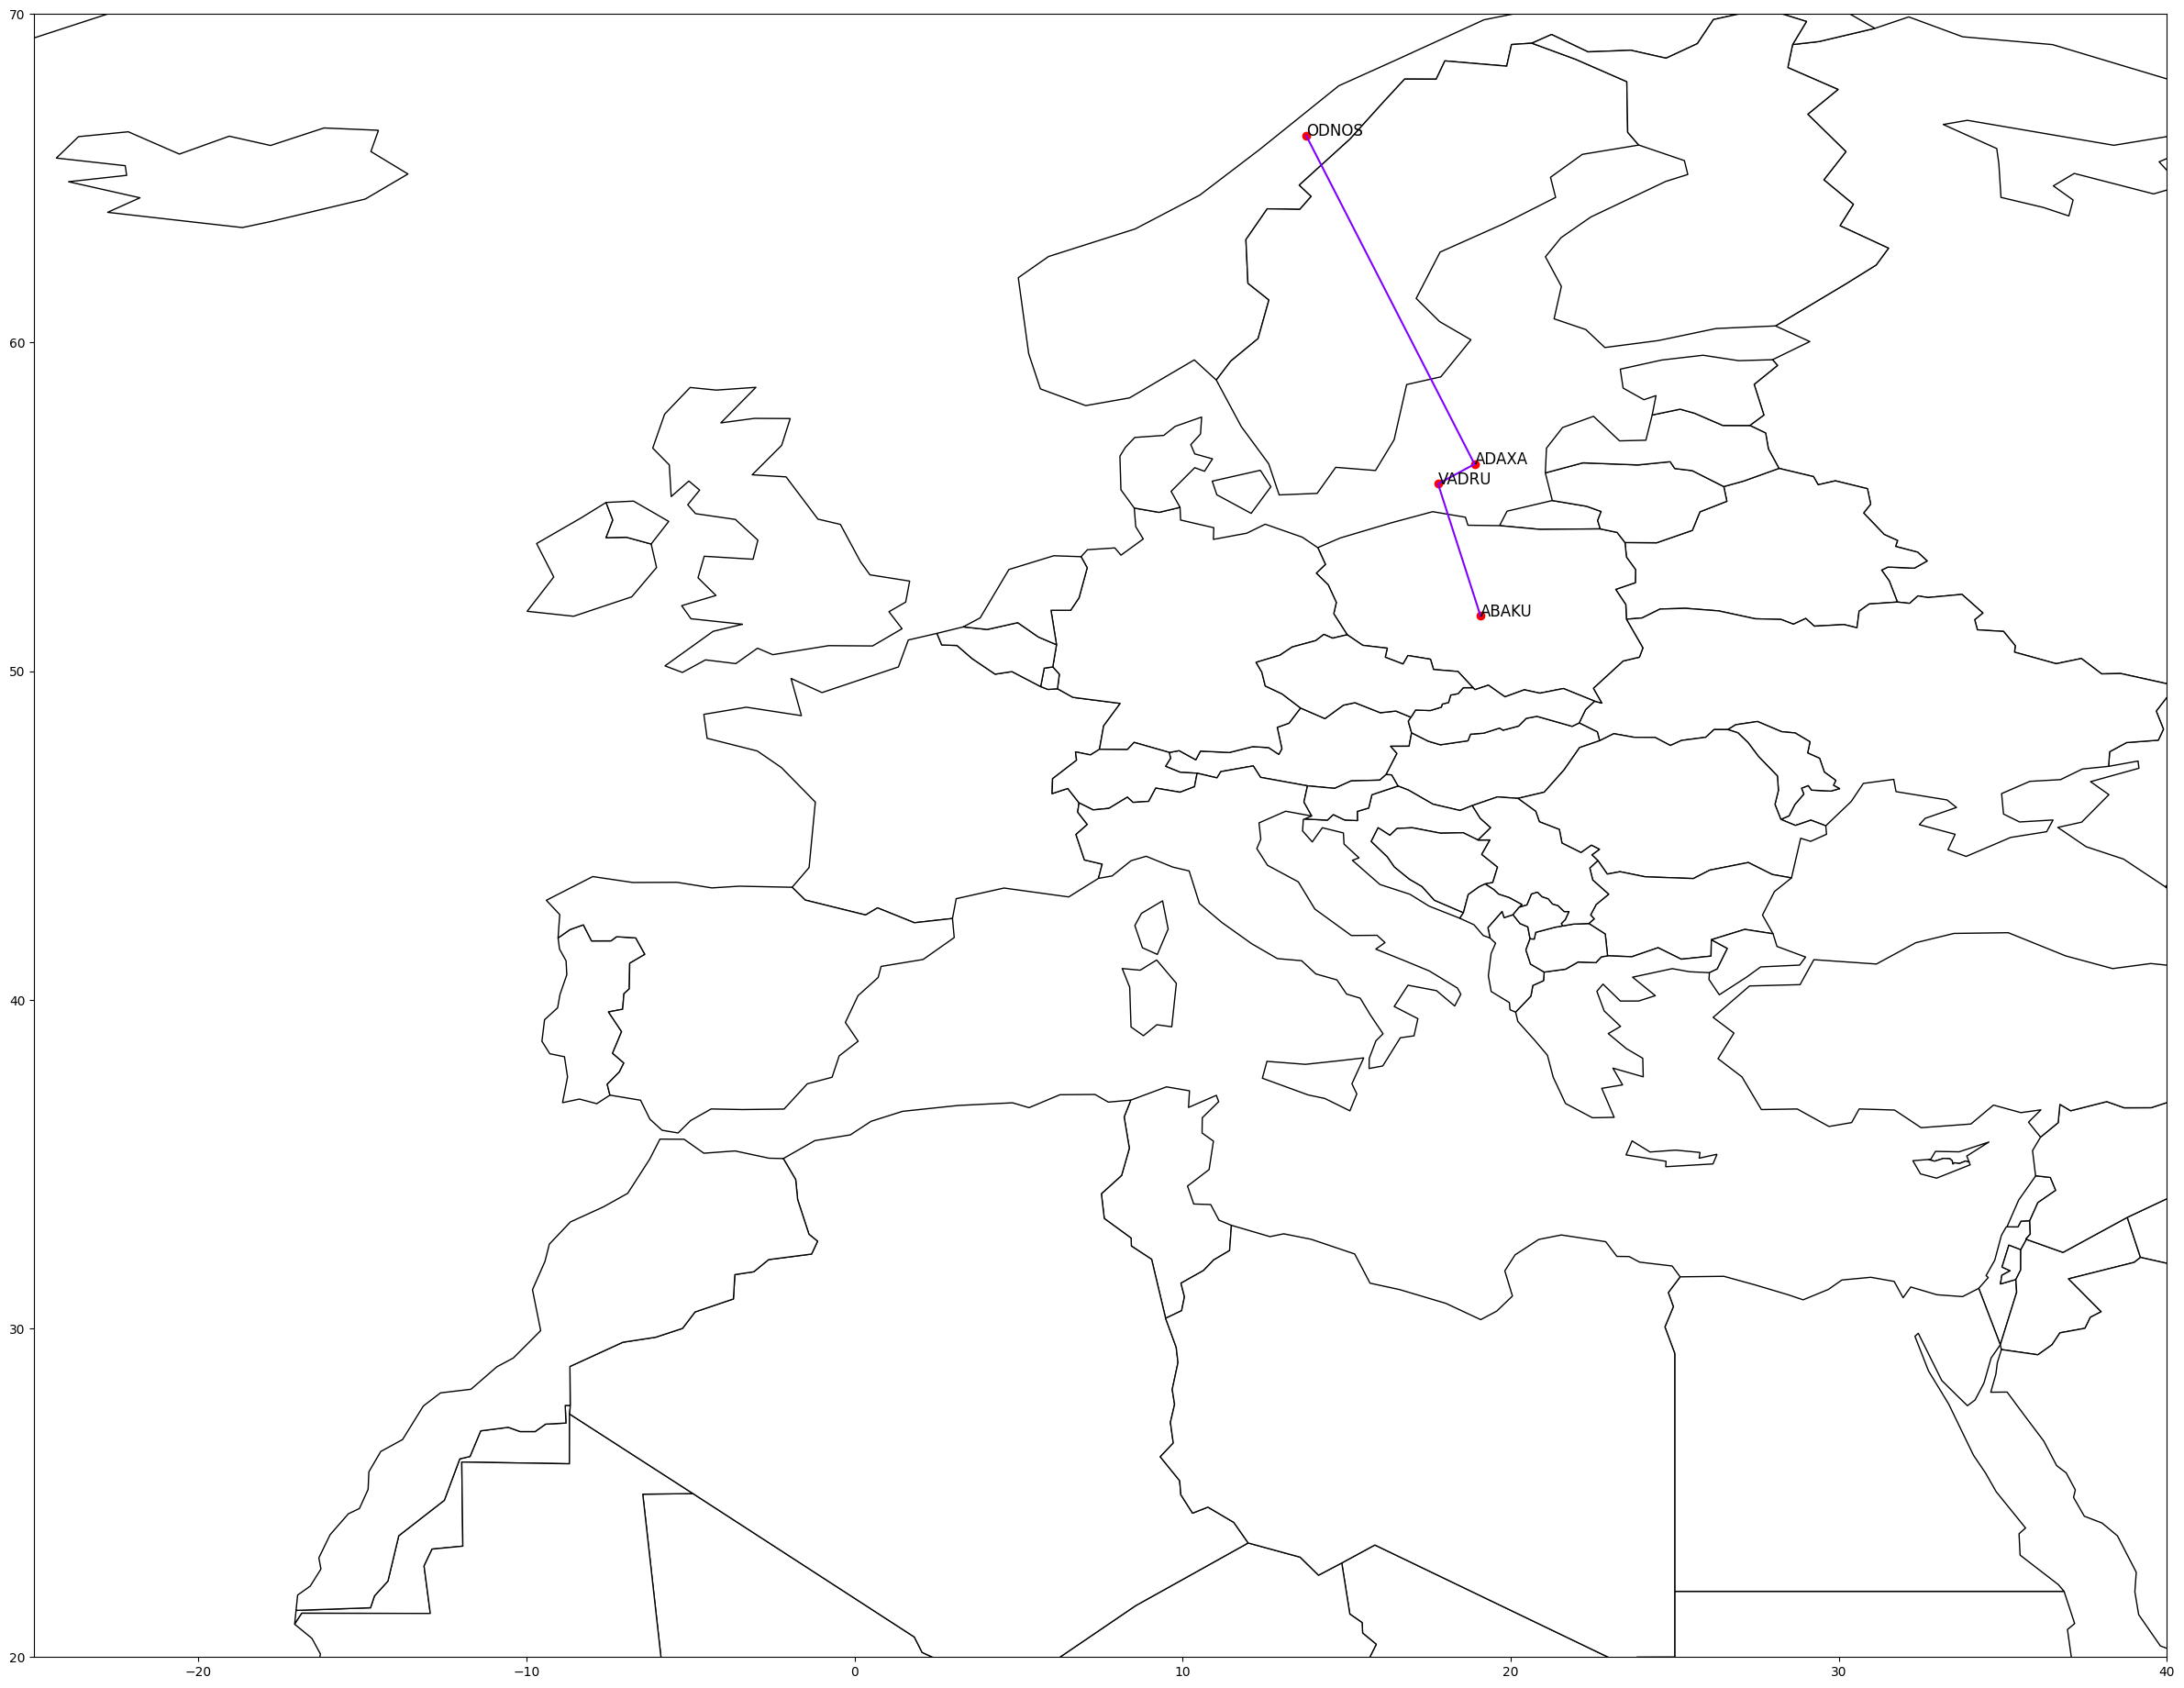

In [31]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# List of routes
routes = [['ABAKU', 'VADRU', 'ADAXA', 'ODNOS']]

# Draw the map
fig, ax = plt.subplots(figsize=(30, 30))
world.plot(ax=ax, color='white', edgecolor='black')

colors = cm.rainbow(np.linspace(0, 1, len(routes)))

for i, route in enumerate(routes):
    # Extract coordinates for each node in the route
    pos = [(node, theGraph[node]['coordinates'][1], theGraph[node]['coordinates'][0]) for node in route]

    # Draw the points on the map
    x_values = [coordinates[1] for coordinates in pos]
    y_values = [coordinates[2] for coordinates in pos]
    ax.scatter(x_values, y_values, color='red')

    # Draw the edges
    ax.plot(x_values, y_values, color=colors[i])

    # Add labels to the points
    for node, x, y in pos:
        ax.text(x, y, node, fontsize=12)

ax.set_xlim(-25, 40)
ax.set_ylim(20, 70)

# Show the plot
plt.show()